This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignment/Week2` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 2.2. Regularization

In this problem, we will use a Ridge Regression model to fit a polynomial that estimates departure delays from the scheduled departure time.

In [205]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
    
from nose.tools import assert_equal, assert_is_not
from numpy.testing import assert_array_equal, assert_almost_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

sns.set(style="white", font_scale=2.0)

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


For simplicity, we limit our analysis to flights that departed from O'Hare. We will try to predict `DepDelay` from `CRSDepTime`.

In [206]:
filename = '/home/data_scientist/data/2001.csv'

usecols = (5, 15, 16)
columns = ['CRSDepTime', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'].dropna()

We are actually going to predict the **average** `DepDelay` in each one-hour blocks of `CRSDepTime`. In other words, we will transform the `local` data set which looks like:

```python
>>> print(local.head())
```

```
      CRSDepTime  DepDelay Origin
6367         951        -8    ORD
6368         951         0    ORD
6369         951        13    ORD
6370         951        17    ORD
6371         951        -1    ORD
```

into a data set that looks like this:

```python
>>> hourly = get_hourly(local)
>>> print(hourly)
```

```
               CRSDepTime   DepDelay
CRSDepTime                          
(500, 600]     595.588556   1.160309
(600, 700]     649.187489   1.922079
(700, 800]     740.461376   4.788713
(800, 900]     838.512038   6.073624
(900, 1000]    941.117287   7.533417
(1000, 1100]  1029.092318   7.959812
(1100, 1200]  1143.347120   8.945600
(1200, 1300]  1237.310490   9.465208
(1300, 1400]  1330.703802  10.080120
(1400, 1500]  1444.372347  12.928801
(1500, 1600]  1528.276364  14.855922
(1600, 1700]  1647.206659  15.155163
(1700, 1800]  1737.540096  16.915603
(1800, 1900]  1836.121684  18.688567
(1900, 2000]  1936.516002  20.037355
(2000, 2100]  2040.102539  18.882328
(2100, 2200]  2131.162948  18.011156
(2200, 2300]  2210.144461  13.627994
```

In [207]:
def get_hourly(df):
    return df.groupby(pd.cut(df['CRSDepTime'], np.arange(0, 2400, 100))).mean().dropna()

hourly = get_hourly(local)
print(hourly)

               CRSDepTime   DepDelay
CRSDepTime                          
(500, 600]     595.588556   1.160309
(600, 700]     649.187489   1.922079
(700, 800]     740.461376   4.788713
(800, 900]     838.512038   6.073624
(900, 1000]    941.117287   7.533417
(1000, 1100]  1029.092318   7.959812
(1100, 1200]  1143.347120   8.945600
(1200, 1300]  1237.310490   9.465208
(1300, 1400]  1330.703802  10.080120
(1400, 1500]  1444.372347  12.928801
(1500, 1600]  1528.276364  14.855922
(1600, 1700]  1647.206659  15.155163
(1700, 1800]  1737.540096  16.915603
(1800, 1900]  1836.121684  18.688567
(1900, 2000]  1936.516002  20.037355
(2000, 2100]  2040.102539  18.882328
(2100, 2200]  2131.162948  18.011156
(2200, 2300]  2210.144461  13.627994


## Plot a linear regression model

Let's start by plotting a scatter plot of (average) `DepDelay` vs. (average) `CRSDepTime` and fitting a linear regression model.

- Use [seaborn.regplot](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.regplot.html) to write a function named `plot_seaborn_reg()` that creates a scatter plot with `CRSDepTime` in the $x$-axis and `DepDelay` in the $y$-axis. The function shuold also fit a linear regression model in the same plot. Note that the function should return an instance of [matplotlib Axes](http://matplotlib.org/users/artists.html) object.

In [208]:
def plot_seaborn_reg(df):
    '''
    Uses Seaborn to create a scatter plot of "DepDelay" vs "CRSDepTime" columns in "df".
    Also fits a linear regression model in the same plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Should have columns named "CRSDepTime" and "DepDelay".
    
    Returns
    -------
    A matplotlib Axes object
    '''
    #####################
    ax = sns.regplot('CRSDepTime', 'DepDelay', df, fit_reg=True, color='blue')
    
    #title and axes
    ax.set_title('DepDelay vs. CRSDepTime')
    ax.set_xlabel('Scheduled Departure Time (local, hhmm)')
    ax.set_ylabel('Departure Delay (min)')
    
    ax.axis([500, 2500, 0, 30])    
    ax.tick_params(axis='x', pad=8)
    sns.despine(offset=0, trim=True)      
    #####################

    return ax

Here's an example:

![](images/regplot.png)

Note that a linear regression model doesn't fit the points that well. The plot suggests that we should probably fit a polynomial rather than a linear model.

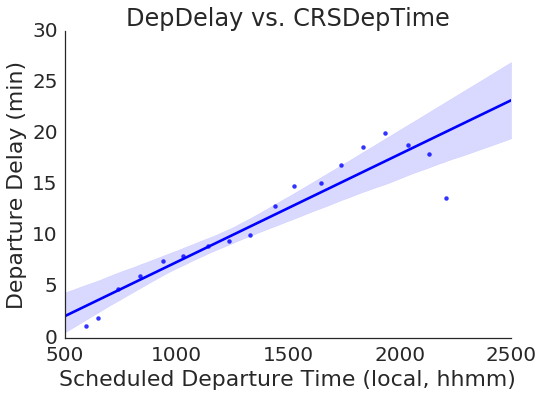

In [209]:
ax1 = plot_seaborn_reg(hourly)

Instructor grades are determined by unit tests like the ones in the following cells.

In [210]:
assert_equal(isinstance(ax1, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax1.lines), 1)
assert_equal(len(ax1.collections), 2, msg="Your plot doesn't have a regression line.")

assert_is_not(len(ax1.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax1.xaxis.get_label_text(), "CRSDepTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax1.yaxis.get_label_text(), "DepDelay", msg="Change the y-axis label to something more descriptive.")
    
x_axis, y_axis = ax1.collections[0].get_offsets().T
assert_array_equal(x_axis, hourly["CRSDepTime"])
assert_array_equal(y_axis, hourly["DepDelay"])

## Fit a polynomial

Use [sklearn.Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to write a function named `fit_reg_poly()` that fits a ridge regression model. Note that the function should return an `sklearn.Pipeline` object, which means you should use [sklearn.pipeline.Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). It should also return the model predictions, so the returned value of this function should a tuple of `(model, predcition)` where `model` is an `sklearn.Pipeline` object and `prediction` is a `numpy.ndarray`.

In [211]:
def fit_reg_poly(df, degree, alpha=1.0):
    '''
    Fits a ridge regression model on "CRSDepTime" to predict "DepDelay".
    
    Parameters
    ----------
    df: A pandas.DataFrame. Must have columns "CRSDepTime" and "DepDelay"
    
    Returns
    -------
    A tuple of (sklearn.Pipeline object, numpy.ndarray)
    '''
    #####################
    
    # Make two dimensional numpy arrays
    y = df['DepDelay'].values[:,np.newaxis]
    X = df['CRSDepTime'].values[:,np.newaxis]
    
    #make pipeline, fit data to model, and then make prediction
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha = alpha))
    model.fit(X, y)
    prediction = model.predict(X)
    #####################

    return model, prediction

In [212]:
est1, pred1 = fit_reg_poly(hourly, 2)
est1_params = est1.get_params()
answer1 = np.array(
    [[  0.96381549], [  2.00110053], [  3.69214664], [  5.40296395], [  7.07592865],
    [  8.4148071 ], [ 10.02196569], [ 11.23220586], [ 12.33539244], [ 13.54395352],
    [ 14.3415839 ], [ 15.33472491], [ 15.98134321], [ 16.58087687], [ 17.07760161],
    [ 17.46971352], [ 17.71340604], [ 17.84824186]]
    )
assert_equal(est1_params['polynomialfeatures__degree'], 2)
assert_equal(est1_params['ridge__alpha'], 1.0)
assert_array_almost_equal(pred1, answer1)

est2, pred2 = fit_reg_poly(hourly, 3, alpha=0.1)
est2_params = est2.get_params()
answer2 = np.array(
    [[  2.51737976], [  2.82297242], [  3.56241564], [  4.61883136], [  5.95441238],
    [  7.2381702 ], [  9.02545887], [ 10.53858495], [ 12.02803632], [ 13.74994808],
    [ 14.90834926], [ 16.3095075 ], [ 17.12919475], [ 17.72501388], [ 17.95314663],
    [ 17.72360238], [ 17.07911122], [ 16.14763616]]
    )
assert_equal(est2_params['polynomialfeatures__degree'], 3)
assert_equal(est2_params['ridge__alpha'], 0.1)
assert_array_almost_equal(pred2, answer2)

## Find the best fit model

Write a function named `find_mse()` that returns the mean squared error of ridge regresion model, given the degree. Assume that alpha is always 1.0.

In [213]:
def find_mse(df, degree):
    '''
    Computes mean squared error of a Ridge Regression model on "df".
    Uses the "fit_reg_poly()" function.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Must have columns "CRSDepTime" and "DepDelay"

    Returns
    -------
    A float.
    '''
    ##################
    y = df['DepDelay'].values[:,np.newaxis]
    
    model, prediction = fit_reg_poly(df, degree)
    result = mean_squared_error(y, prediction)
    ##################
    return result

We will use this function to find the degree of polynomial that best fits our data.

In [214]:
degrees = list()
for i in range(1, 15):
    degrees.append(find_mse(hourly, i))

best_degree = np.argmin(degrees) + 1 # because degree = 1 corresponds to arg = 0
print('The best model is a polynomial of degree {}.'.format(best_degree))

The best model is a polynomial of degree 11.


Let's run some tests to see if `find_best_degree()` works.

In [215]:
assert_almost_equal(find_mse(hourly, 1), 4.18136713)
assert_almost_equal(find_mse(hourly, 2), 2.56253754)
assert_almost_equal(find_mse(hourly, 3), 1.67377024)
assert_almost_equal(find_mse(hourly, 4), 0.26596999)
assert_almost_equal(find_mse(hourly, 5), 0.24159061)

## Plot the ridge regression model

Finally, plot the model we learned with `fit_reg_poly()`. Your plot should have both the scatter plot of `DepDelay` vs. `CRSDepTime` and the line that shows the ridge regression model.

Note that the `plot_reg_poly()` returns a `matplotlib.Axes` object.

In [253]:
def plot_reg_ploy(df, degree):
    '''
    Plots the follwoing:
    1. A scatter plot of the "CRSDepTime" column of "df" on the x-axis
       and the "DepDelay" column of "df" on the y-axis,
    2. A line that represents a polynomial of degree "degree".
              
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A matplotlib.Axes object
    '''
    #####################
    ax = sns.regplot('CRSDepTime', 'DepDelay', df, fit_reg=False, color='blue')
    
    model, prediction = fit_reg_poly(df, degree)
    
    y = prediction
    X = df['CRSDepTime']   
    plt.plot(X,y)
    
    #title and axes
    ax.set_title('DepDelay vs. CRSDepTime')
    ax.set_xlabel('Scheduled Departure Time (local, hhmm)')
    ax.set_ylabel('Departure Delay (min)')
    
    ax.axis([500, 2500, 0, 30])    
    ax.tick_params(axis='x', pad=8)
    sns.despine(offset=0, trim=True)
    #####################
    return ax

Here's an example:

![](images/polyfit.png)

The regularized polynomial fits the data very well, but note that we have applied our model to the same data set that we used to learn our model. We did this to simplify the problem and focus on learning the procedure, but by using the same training data to evaulate the performance of our model, it is very likely that we are overfitting. A more robust approach would be to split the data set into a training set and a test set (or training-validation-test sets), use the training set to learn a model, use the validation set to find the degree of best-fit polynomial, and evaulate the model's performance on the test set.

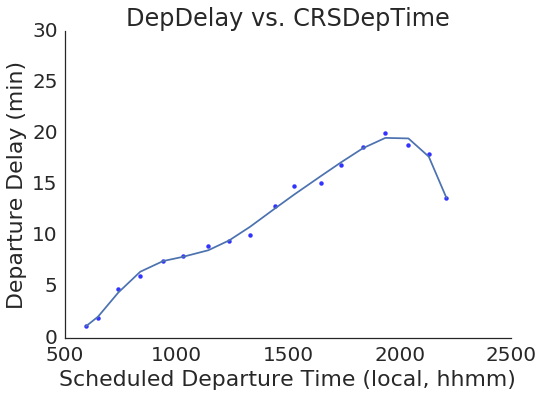

In [254]:
ax2 = plot_reg_ploy(hourly, best_degree)

In [255]:
assert_equal(isinstance(ax2, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax2.lines), 1)
assert_equal(len(ax2.collections), 1, msg="You should turn off Seaborn regression.")

assert_is_not(len(ax2.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax2.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax2.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x_scatter, y_scatter = ax2.collections[0].get_offsets().T
assert_array_equal(x_scatter, hourly["CRSDepTime"])
assert_array_equal(y_scatter, hourly["DepDelay"])

line = ax2.get_lines()[0]
x_line = line.get_xdata()
y_line = line.get_ydata()
assert_array_equal(x_line, hourly["CRSDepTime"])
assert_array_almost_equal(y_line[:, np.newaxis], fit_reg_poly(hourly, 11)[1])